# From A/B to B/A/Y/E/S :)

**Goal:** Show that Bayesian sequential testing lets you stop experiments early with the same confidence as traditional testing.

## Example Scenario

E-commerce checkout button test:
- **Variant A (control):** Current button, 10% conversion
- **Variant B (treatment):** New button, 12% conversion (20% relative lift)
- Question: How quickly can we detect this?

## Background

Traditional A/B testing:
- Pre-specify sample size (e.g., n=1,000 per variant)
- **Cannot peek** at results without inflating false positive rate
- Must wait for full sample even if winner is obvious

Bayesian sequential testing:
- Check results **anytime** without penalty
- Stop when confident enough (e.g., P(B > A) > 0.95)
- Often stops much earlier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import myplotlib as my
from scipy import stats

import sys
sys.path.insert(0, '../src')
from bayesian_ab.simulation import simulate_ab_test

## 1. Frequentist A/B test

### Power analysis

We'll want to be able to detect a minimum effect of 10% uplift (i.e., a 10% increase over the current rate). For this, we'll also need to know the current rate. We'll assume 10%. So 10% uplift correspond to a difference of 1%.

We really don't want to miss out on finding an effect, so we plan for 95% power. Standard alpha level of 0.05.

In [428]:
from statsmodels.stats.power import zt_ind_solve_power

true_p_control = 0.10
p_control = true_p_control
p_mde = 0.20
mde = true_p_control * p_mde
p_treatment = true_p_control + mde
power = 0.80
alpha = 0.05


# Effect size (Cohen's h for proportions)
from statsmodels.stats.proportion import proportion_effectsize
effect_size = proportion_effectsize(p_treatment, p_control)

# Required sample size per group
n_per_group = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    ratio=1.0,  # Equal group sizes
    alternative='larger'  # hypothesis is that we increase conversion
)

power_result = {
        'n_per_group': int(np.ceil(n_per_group)),
        'total_n': int(np.ceil(n_per_group * 2)),
        'effect_size': effect_size,
        'relative_lift': (p_treatment - p_control) / p_control * 100,
        'absolute_difference': p_treatment - p_control,
    }
power_result

{'n_per_group': 3021,
 'total_n': 6042,
 'effect_size': np.float64(0.06398210298605866),
 'relative_lift': 20.000000000000004,
 'absolute_difference': 0.020000000000000004}

Data come in batches. Let's say we can obtain a `daily_n` of 1000.

In [429]:
daily_n = 500
n_days = int(np.ceil(power_result["n_per_group"] / daily_n))

print((
    f"We need {n_days} days with {daily_n} data points per day for each group\n"
    f"to detect a minimum effect of {100 * mde:.2f}% with a power of {100 * power:.2f}%\n"
    f"at a false positive rate of {100*alpha:.2f}%."
))

We need 7 days with 500 data points per day for each group
to detect a minimum effect of 2.00% with a power of 80.00%
at a false positive rate of 5.00%.


## 2. Simulate data from this experiment

In [430]:
# Simulate 14 days, 100 visitors per variant per day
true_p_treatment = true_p_control + mde # Treatment: 10% lift

print(f"True control rate:\t{true_p_control*100:.2f}%")
print(f"True treatment rate:\t{true_p_treatment*100:.2f}%")

data = simulate_ab_test(
    n_days=n_days,
    daily_n=daily_n,
    p_a=true_p_control,  
    p_b=true_p_treatment,
    seed=123
)

data.head()

True control rate:	10.00%
True treatment rate:	12.00%


,day,variant,conversions,n
0,1,A,53,500
1,1,B,59,500
2,2,A,54,500
3,2,B,49,500
4,3,A,51,500


In [431]:
# Add business labels for presentation
data['button_type'] = data['variant'].map({'A': 'Current Button', 'B': 'New Button'})
data['purchases'] = data['conversions']
data['visitors'] = data['n']
data['purchase_rate'] = data['purchases'] / data['visitors']

data[['day', 'button_type', 'visitors', 'purchases', 'purchase_rate']].head(10)

,day,button_type,visitors,purchases,purchase_rate
0,1,Current Button,500,53,0.106
1,1,New Button,500,59,0.118
2,2,Current Button,500,54,0.108
3,2,New Button,500,49,0.098
4,3,Current Button,500,51,0.102
5,3,New Button,500,70,0.140
6,4,Current Button,500,52,0.104
7,4,New Button,500,62,0.124
8,5,Current Button,500,44,0.088
9,5,New Button,500,64,0.128


In [432]:
final_data = data.groupby('variant')[['conversions', 'n']].sum()
final_data

,conversions,n
variant,,
A,358,3500
B,429,3500


## 2. EDA / Visualization

Calculate cumulative conversions and sample sizes up to each day:

In [433]:
from statsmodels.stats.proportion import proportion_confint

In [434]:
cumulative = data.groupby(['variant']).apply(
    lambda x: pd.DataFrame({
        'day': x['day'],
        'cumulative_n': x['n'].cumsum(),
        'cumulative_conversions': x['conversions'].cumsum(),
    }), include_groups=False
).reset_index(drop=False).drop("level_1", axis=1)
cumulative["cumulative_rate"] = cumulative["cumulative_conversions"] / cumulative['cumulative_n']

wilson_ci = proportion_confint(count=cumulative["cumulative_conversions"], 
                               nobs=cumulative["cumulative_n"], 
                               method="normal",
                               alpha=0.05)

cumulative["ci_lower"] = wilson_ci[0]
cumulative["ci_upper"] = wilson_ci[1]
cumulative.groupby("variant").head(3)

,variant,day,cumulative_n,cumulative_conversions,cumulative_rate,ci_lower,ci_upper
0,A,1,500,53,0.106000,0.079017,0.132983
1,A,2,1000,107,0.107000,0.087841,0.126159
2,A,3,1500,158,0.105333,0.089798,0.120869
7,B,1,500,59,0.118000,0.089723,0.146277
8,B,2,1000,108,0.108000,0.088763,0.127237
9,B,3,1500,178,0.118667,0.102301,0.135032


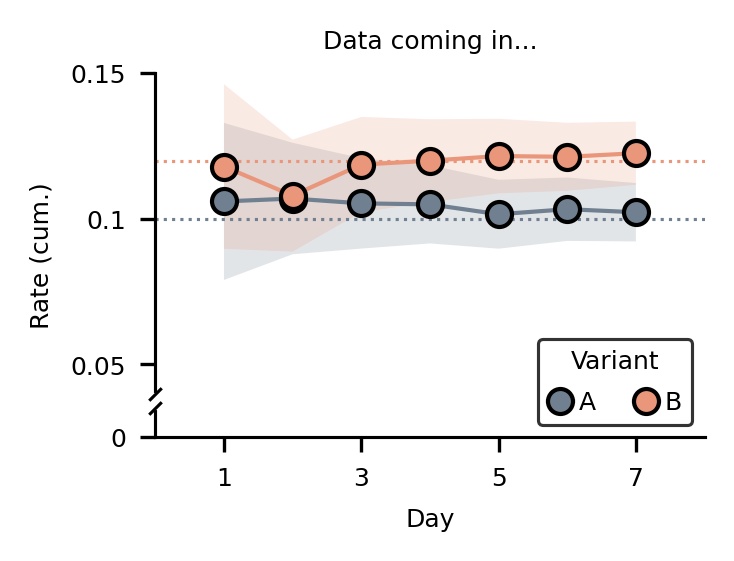

In [435]:
fig, ax = plt.subplots(figsize=my.utilities.cm2inch(6, 4))

# Plot truth
ax.axhline(true_p_control, c='C0', lw=0.75, ls=':')
ax.axhline(true_p_treatment, c='C1', lw=0.75, ls=':')

for variant in ["A", "B"]:
    df = cumulative.query("variant == @variant")
    ax.plot(df["day"], df["cumulative_rate"], '-o', label=variant, clip_on=False)

    # let's add some confidence bands
    ## compute wilson confidence intervals
    ax.fill_between(df['day'], df['ci_lower'], df["ci_upper"], alpha=0.2)

ax.set_xlim(0, n_days + 1)
ax.set_ylim(0.05, 0.15)
ax.set_yticks([0.025, 0.05, 0.1, 0.15])
my.utilities.break_after_nth_tick(ax, 0, axis="y", where=0.5, occHeight=0.005)
ax.set_yticklabels([0, 0.05, 0.1, 0.15])
ax.set_xticks(np.arange(1, n_days+1, 2))
ax.set_xlabel("Day")
ax.set_ylabel("Rate (cum.)")
ax.legend(title="Variant", ncols=2, loc="lower right")
ax.set_title("Data coming in...");

## Frequentist test

After all data are in (only last day slice in the figure)

In [436]:
final_data = data.groupby("variant")[["conversions", "n"]].sum()
final_data["rate"] = final_data["conversions"] / final_data["n"]
final_data

,conversions,n,rate
variant,,,
A,358,3500,0.102286
B,429,3500,0.122571


In [437]:
effect = final_data.loc['B']['rate'] - final_data.loc['A']['rate']
print(f"Descriptively, this is a {effect * 100:.2f}% increase for variant B. But is that meaningful?")

Descriptively, this is a 2.03% increase for variant B. But is that meaningful?


In [441]:
from statsmodels.stats.proportion import proportions_ztest

# Traditional test on final data
counts = [final_data.loc['B', 'conversions'], final_data.loc['A', 'conversions']]
nobs = [final_data.loc['B', 'n'], final_data.loc['A', 'n']]
z_stat, p_value = proportions_ztest(counts, nobs, alternative="larger")

print(f"Traditional Two-Proportion Z-Test (Full {n_days} Days):")
print(f"  z-statistic: {z_stat:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant at α=0.05? {p_value < 0.05}")
print(f"\n  Sample size used: {final_data.loc['A', 'n']} per variant")
print(f"  Experiment duration: {n_days} days")

Traditional Two-Proportion Z-Test (Full 7 Days):
  z-statistic: 2.686
  p-value: 0.0036
  Significant at α=0.05? True

  Sample size used: 3500 per variant
  Experiment duration: 7 days


## 3. Bayesian Sequential Analysis

### Key idea: Beta-Binomial Model

For each variant:
- **Prior:** Beta(1, 1) = Uniform
- **Likelihood:** Binomial(conversions | n, p)
- **Posterior:** Beta(1 + conversions, 1 + failures)

This is **conjugate** - posterior has same form as prior, so updating is trivial!

In [443]:
def bayesian_update(conversions, n, prior_alpha=1, prior_beta=1):
    """
    Update Beta prior with binomial data.
    
    Returns Beta distribution parameters.
    """
    failures = n - conversions
    posterior_alpha = prior_alpha + conversions
    posterior_beta = prior_beta + failures
    return posterior_alpha, posterior_beta

def prob_b_beats_a(alpha_a, beta_a, alpha_b, beta_b, n_samples=10000):
    """
    Calculate P(B > A) via Monte Carlo sampling.
    """
    samples_a = np.random.beta(alpha_a, beta_a, n_samples)
    samples_b = np.random.beta(alpha_b, beta_b, n_samples)
    return np.mean(samples_b > samples_a)

### Sequential Checking: When Can We Stop?

Check each day if P(B > A) > 0.95 (our stopping threshold):

In [444]:
# For each day, calculate P(B > A)
results = []

for day in range(1, n_days + 1):
    # Get cumulative data up to this day
    day_data = data[data['day'] <= day].groupby('variant')[['conversions', 'n']].sum()
    
    # Update posteriors
    alpha_a, beta_a = bayesian_update(day_data.loc['A', 'conversions'], day_data.loc['A', 'n'])
    alpha_b, beta_b = bayesian_update(day_data.loc['B', 'conversions'], day_data.loc['B', 'n'])
    
    # Calculate P(B > A)
    prob = prob_b_beats_a(alpha_a, beta_a, alpha_b, beta_b)
    
    results.append({
        'day': day,
        'n_per_variant': day_data.loc['A', 'n'],
        'prob_b_better': prob,
        'should_stop': prob > 0.95
    })

results_df = pd.DataFrame(results)
results_df

,day,n_per_variant,prob_b_better,should_stop
0,1,500,0.7241,False
1,2,1000,0.5282,False
2,3,1500,0.8809,False
3,4,2000,0.9317,False
4,5,2500,0.9886,True
5,6,3000,0.9877,True
6,7,3500,0.9956,True


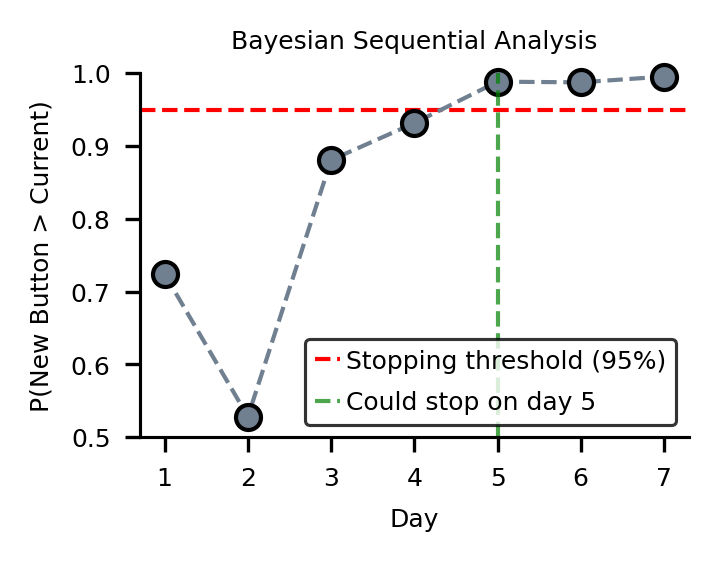


✓ Could stop on day 5 with 95% confidence
  Sample size: 2500 per variant
  vs. 3500 if we waited full 7 days
  Savings: 29% reduction in experiment duration


In [445]:
# Plot probability over time
fig, ax = plt.subplots(figsize=my.utilities.cm2inch(6, 4))

ax.axhline(0.95, color='red', linestyle='--', label='Stopping threshold (95%)')
ax.plot(results_df['day'], results_df['prob_b_better'], '--o', clip_on=False)

# Mark first day we could stop
stop_day = results_df[results_df['should_stop']]['day'].min()
if pd.notna(stop_day):
    ax.axvline(stop_day, color='green', linestyle='--', alpha=0.7, label=f'Could stop on day {int(stop_day)}')

ax.set_xlabel('Day')
ax.set_ylabel('P(New Button > Current)')
ax.set_ylim(0.5, 1)
ax.set_title('Bayesian Sequential Analysis')
ax.legend()
plt.show()

if pd.notna(stop_day):
    print(f"\n✓ Could stop on day {int(stop_day)} with 95% confidence")
    print(f"  Sample size: {int(results_df[results_df['day'] == stop_day]['n_per_variant'].values[0])} per variant")
    print(f"  vs. {data.groupby('variant')['n'].sum().values[0]} if we waited full {n_days} days")
    print(f"  Savings: {100 * (1 - stop_day/n_days):.0f}% reduction in experiment duration")

## 4. Posterior Distributions

Visualize what we learned about conversion rates:

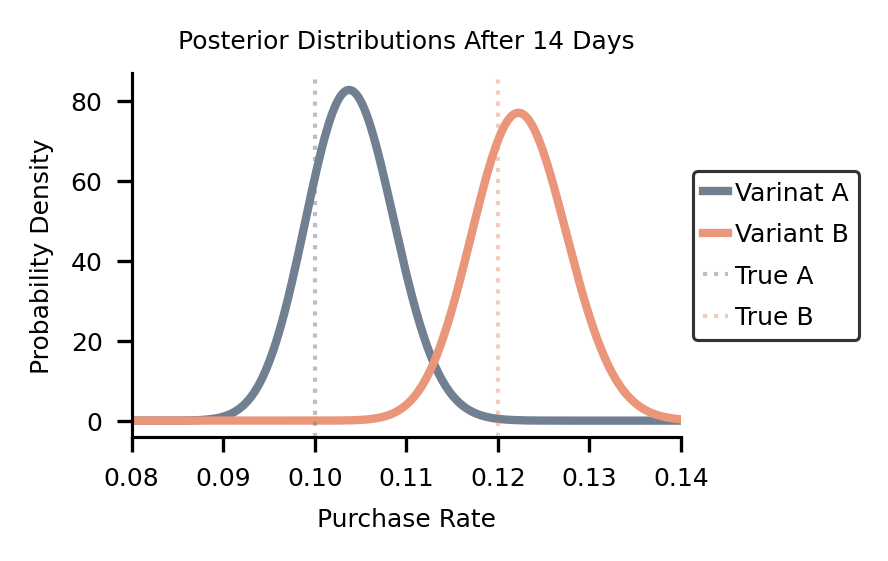

Posterior means:
  A: 0.104
  B: 0.122

95% Credible Intervals:
  A: [0.095, 0.114]
  B: [0.112, 0.133]


In [422]:
# Get final day posteriors
alpha_a, beta_a = bayesian_update(final_data.loc['A', 'conversions'], final_data.loc['A', 'n'])
alpha_b, beta_b = bayesian_update(final_data.loc['B', 'conversions'], final_data.loc['B', 'n'])

# Plot posteriors
x = np.linspace(0, 0.20, 1000)
fig, ax = plt.subplots(figsize=my.utilities.cm2inch(6, 4))

ax.plot(x, stats.beta.pdf(x, alpha_a, beta_a), label='Variant A', linewidth=2)
ax.plot(x, stats.beta.pdf(x, alpha_b, beta_b), label='Variant B', linewidth=2)
ax.axvline(0.10, color='C0', linestyle=':', alpha=0.5, label=f'True A')
ax.axvline(0.12, color='C1', linestyle=':', alpha=0.5, label=f'True B')

ax.set_xlim(0.08, 0.14)
ax.set_xlabel('Purchase Rate')
ax.set_ylabel('Probability Density')
ax.set_title('Posterior Distributions After 14 Days')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Summary stats
print(f"Posterior means:")
print(f"  A: {alpha_a/(alpha_a + beta_a):.3f}")
print(f"  B: {alpha_b/(alpha_b + beta_b):.3f}")
print(f"\n95% Credible Intervals:")
print(f"  A: [{stats.beta.ppf(0.025, alpha_a, beta_a):.3f}, {stats.beta.ppf(0.975, alpha_a, beta_a):.3f}]")
print(f"  B: [{stats.beta.ppf(0.025, alpha_b, beta_b):.3f}, {stats.beta.ppf(0.975, alpha_b, beta_b):.3f}]")

## Key Takeaways

1. **Bayesian sequential testing** reaches the same conclusion faster
2. **No peeking problem** - can check results anytime
3. **Richer information** - full posterior distributions, not just p-values
4. **Interpretable** - "95% probability B is better" vs "p < 0.05"

## Next Steps

- Add ROPE (Region of Practical Equivalence) for "variants are equivalent" conclusions
- Simulate multiple experiments to check false positive rates
- Build interactive dashboard with Streamlit
- Compare different stopping rules